In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import qutip as qt
from qutip_qip.operations import gate_sequence_product
from qutip_qip.circuit import CircuitSimulator
from time import process_time
from math import frexp, ldexp

#necessary to avoid a Tensorflow issue on my PC
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import sys
print (sys.version)
# 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
import tensorflow as tf
print("Tensorflow version: "+tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.9.1
Num GPUs Available:  0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import basis, fidelity
from qutip_qip.device import LinearSpinChain
from qutip_qip.algorithms import qft_gate_sequence

def roundbits(fval, nbits):
    """Return the floating-point value `fval` rounded to `nbits` bits
    in the significand."""
    significand, exponent = frexp(fval)
    scale = 2.0 ** nbits
    newsignificand = round(significand * scale) / scale
    return ldexp(newsignificand, exponent)

def gate_apply(gate,state_vector,data_type=tf.float32,normalize=False):
    '''Function which converts gates and state vector into desired precision, then multiplies them. 
    The output state vector is recast into a QuTiP quantum object.'''
    if type(data_type) == str:
        mantissa_bits = int(data_type[-1])
        real_gate = np.stack(np.vectorize(roundbits)(tf.cast(np.real(gate.full()),dtype=tf.float16),mantissa_bits), axis=1)
        imag_gate = np.stack(np.vectorize(roundbits)(tf.cast(np.imag(gate.full()),dtype=tf.float16),mantissa_bits), axis=1)
        
        real_state = np.stack(np.vectorize(roundbits)(tf.cast(np.real(state_vector.full()),dtype=tf.float16),mantissa_bits), axis=0)
        imag_state = np.stack(np.vectorize(roundbits)(tf.cast(np.imag(state_vector.full()),dtype=tf.float16),mantissa_bits), axis=0)
        
    else:
        real_gate = tf.cast(np.real(gate.full()),dtype=data_type)
        imag_gate = tf.cast(np.imag(gate.full()),dtype=data_type)

        real_state = tf.cast(np.real(state_vector.full()),dtype=data_type)
        imag_state = tf.cast(np.imag(state_vector.full()),dtype=data_type)

    real_final_state = tf.tensordot(real_gate,real_state,axes=1)-tf.tensordot(imag_gate,imag_state,axes=1)
    imag_final_state = tf.tensordot(imag_gate,real_state,axes=1)+tf.tensordot(real_gate,imag_state,axes=1)

    final_state = qt.Qobj(real_final_state.numpy()+1j*imag_final_state.numpy(),dims=state_vector.dims)
    
    if normalize == True:
        final_state = final_state.unit()
    
    return final_state

# Start the stopwatch / counter
t1_start = process_time()

# normalize_states?
normalize_states = True
# Set the Number of Qubits
num_qubits = 5
# Initial State
int_state = basis([2]*num_qubits, [0]*num_qubits)
# The QFT circuit
qc = qft_gate_sequence(num_qubits, swapping=False, to_cnot=True)
# sets the number of times to repeat the circuit (e.g. repeat=1 means the circuit is repeated once, for 2 total applications
# of the circuit)
repeat = 30
for i in range(repeat):
    qc.add_circuit(qft_gate_sequence(num_qubits, swapping=False, to_cnot=True))
# Gate-level simulation
state1 = qc.run(int_state)
# Pulse-level simulation
#processor = LinearSpinChain(num_qubits)
#processor.load_circuit(qc)
#state2 = processor.run_state(int_state).states[-1]
#print(fidelity(state1, state2))

gates = qc.propagators()
print('Number of total gates: '+str(len(gates)))

# Stop the stopwatch / counter
t1_stop = process_time()
print("Elapsed time during QuTiP circuit simulation in seconds:", t1_stop-t1_start)

Number of total gates: 2015
Elapsed time during QuTiP circuit simulation in seconds: 19.078125


In [4]:
#This codeblock just checks that the function gate_apply works as intended for all precisions by multiplying all gates
#together first, then calling gate_apply using that matrix and the initial state. Since there won't be any error propogation
#throughout the circuit, we expect all of these fidelities to be close to 1 (although lower for smaller precisions).

# Start the stopwatch / counter
t2_start = process_time()
# [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16,'float8','float7']
for precision in ['float6','float5','float4','float3','float2','float1']:
    if type(precision) == str:
        precision_string = str(precision)
    else:
        precision_string = str(precision)[str(precision).find(' ')+2:-2]
    final_state = gate_apply(gate_sequence_product(gates),int_state,precision)
    print("Fidelity for percision "+precision_string+" is "+str(fidelity(final_state,state1)))
    
# Stop the stopwatch / counter
t2_stop = process_time()
print("Elapsed time during Final State fidelity check across precisions in seconds:", t2_stop-t2_start)

Fidelity for percision float6 is 0.9986572437695685
Fidelity for percision float5 is 1.0430908405336958
Fidelity for percision float4 is 0.9552002082687109
Fidelity for percision float3 is 1.1328125112347007
Fidelity for percision float2 is 1.1328125112347007
Fidelity for percision float1 is 0.5078125078864332
Elapsed time during Final State fidelity check across precisions in seconds: 7.796875


In [4]:
# This codeblock tracks the state vector evolution after every gate application using QuTiP's native simulation engine. 
# We will use this series of state vectors to compare our results to using different precisions.

# Start the stopwatch / counter
t3_start = process_time()

#set up baseline using QuTIP native simulation
sim = CircuitSimulator(qc, state=int_state)
state_vector = int_state
vector_list_baseline = []
vector_list_baseline.append(state_vector)
for i in range(len(gates)):
    state_vector = sim.step()
    if normalize_states == True:
        state_vector = state_vector.unit()
    vector_list_baseline.append(state_vector)
if normalize_states == True:
    qt.qsave(vector_list_baseline, 'vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+"_normalized")
else:
    qt.qsave(vector_list_baseline, 'vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat))

# Stop the stopwatch / counter
t3_stop = process_time()
print("Elapsed time during baseline state vector evolution in seconds:", t3_stop-t3_start)

Elapsed time during baseline state vector evolution in seconds: 3.546875


In [158]:
#set up baseline w/ highest percision
#precision_baseline = tf.complex128
#state_vector = int_state
#vector_list_baseline = []
#vector_list_baseline.append(state_vector)
#for index,gate in enumerate(gates):
#    state_vector = gate_apply(gate,state_vector,data_type=precision)
#    vector_list_baseline.append(state_vector)
# need to edit the filename if the precision changes
#qt.qsave(vector_list_baseline, 'vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision_baseline)[str(precision_baseline).find('complex'):-2])

In [296]:
# As above, this codeblock keeps track of the state vector evolution throughout the circuit, but this time using the specified
# precisions. Each result is saved as a QuTiP file to be accessed later without having to redo calculations.

# Start the stopwatch / counter
t4_start = process_time()

#set up test w/ different percision
#precisions_to_test = [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16,'float8','float7']
precisions_to_test = ['float6','float5','float4','float3','float2','float1']

for precision in precisions_to_test:
    vector_list = []
    state_vector = int_state
    vector_list.append(state_vector)
    for gate in gates:
        if normalize_states == True:
            state_vector = gate_apply(gate,state_vector,data_type=precision,normalize=True)
        else:
            state_vector = gate_apply(gate,state_vector,data_type=precision)
        vector_list.append(state_vector)
    if normalize_states == True:
        if type(precision) == str:
            filename = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision+'_normalized'
        else:
            filename = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized'
    else:
        if type(precision) == str:
            filename = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision
        else:
            filename = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    qt.qsave(vector_list,filename)
    
# Stop the stopwatch / counter
t4_stop = process_time()
print("Elapsed time during test state vector evolution in seconds:", t4_stop-t4_start)

Elapsed time during test state vector evolution in seconds: 23282.234375


Elapsed time during fidelity plotting evolution in seconds: 34652.40625


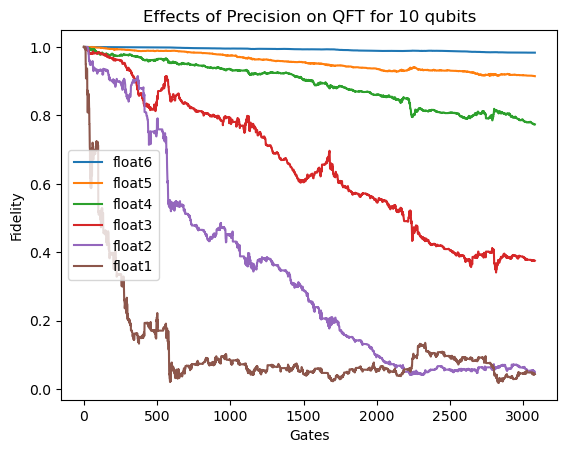

In [297]:
# Computes, then plots the fidelity of each state vector at every precision vs. the baseline.

# Start the stopwatch / counter
t5_start = process_time()

if normalize_states == True:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_normalized')
else:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat))
fig = plt.figure()
for precision in precisions_to_test:
    if normalize_states == True:
        if type(precision) == str:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision+'_normalized'
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision+'_normalized'      
        else:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized'
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized'      
    else:
        if type(precision) == str:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision
        else:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]

    if type(precision) == str:
        precision_string = precision
    else:
        precision_string = str(precision)[str(precision).find(' ')+2:-2]
    
    vector_list = qt.qload(loadname)
    fidelity_list = []
    for i in range(len(vector_list)):
        fidelity_list.append(fidelity(vector_list[i],vector_list_baseline[i]))
    qt.qsave(fidelity_list,savename)   
    plt.plot(fidelity_list,label=precision_string)
plt.title('Effects of Precision on QFT for '+str(num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
if normalize_states == True:
    fig.savefig('Effects of Precision on QFT for '+str(num_qubits)+' qubits'+'_circuit_repeats_'+str(repeat)+'_normalized'+'.jpg')
else:
    fig.savefig('Effects of Precision on QFT for '+str(num_qubits)+' qubits'+'_circuit_repeats_'+str(repeat)+'.jpg')
# Stop the stopwatch / counter
t5_stop = process_time()
print("Elapsed time during fidelity plotting evolution in seconds:", t5_stop-t5_start)

Elapsed time during fidelity plotting evolution in seconds: 14.5


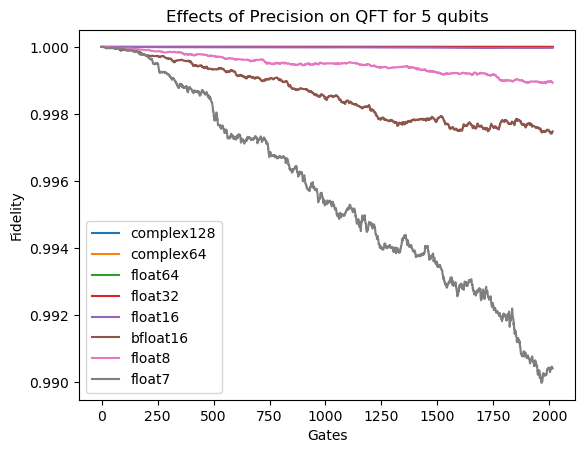

In [212]:
# Post Normalization
normalize_states_2 = False
# Start the stopwatch / counter
t6_start = process_time()

if normalize_states_2 == True:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_normalized')
else:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat))
fig = plt.figure()
for precision in precisions_to_test:
    if normalize_states == True:
        if type(precision) == str:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision+'_normalized'
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision+'_normalized'      
        else:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized'
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized'      
    else:
        if type(precision) == str:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision
        else:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]

    if type(precision) == str:
        precision_string = precision
    else:
        precision_string = str(precision)[str(precision).find(' ')+2:-2]
    vector_list = qt.qload(loadname)
    fidelity_list = []
    for i in range(len(vector_list)):
        fidelity_list.append(fidelity(vector_list[i].unit(),vector_list_baseline[i].unit())) #normalizing before fidelity
    #qt.qsave(fidelity_list,savename)   
    plt.plot(fidelity_list,label=precision_string)
plt.title('Effects of Precision on QFT for '+str(num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
fig.savefig('Effects of Precision on QFT for '+str(num_qubits)+' qubits'+'_circuit_repeats_'+str(repeat)+'post_normalization'+'.jpg')

# Stop the stopwatch / counter
t6_stop = process_time()
print("Elapsed time during fidelity plotting evolution in seconds:", t6_stop-t6_start)

Elapsed time during fidelity plotting evolution in seconds: 0.578125


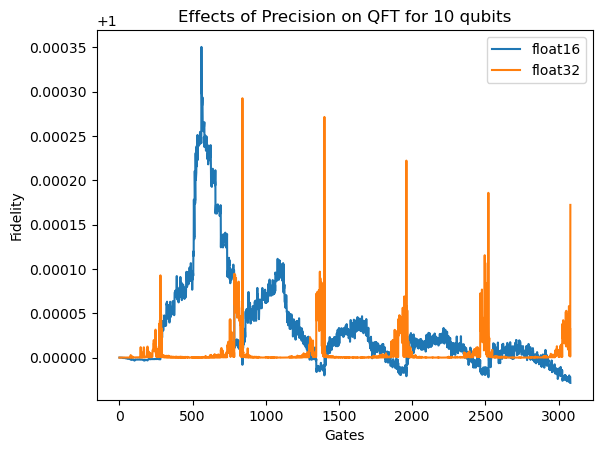

In [9]:
# Plotting Testbed
#load_num_qubits = num_qubits
#load_repeat = repeat
load_num_qubits = 10
load_repeat = 10

saving = False
normal = True
#list_precision = [tf.float16,tf.bfloat16,'float8','float7','float6','float5','float4','float3','float2','float1']
list_precision = [tf.float16,tf.float32]

# Start the stopwatch / counter
t10_start = process_time()

if normal == True:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_normalized')
else:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat))
fig2 = plt.figure()
for precision in list_precision:
    if normal == True:
        if type(precision) == str:
            loadname = 'fidelity_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+precision+'_normalized'      
        else:
            loadname = 'fidelity_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized'      
    else:
        if type(precision) == str:
            loadname = 'fidelity_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+precision
        else:
            loadname = 'fidelity_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]

    if type(precision) == str:
        precision_string = precision
    else:
        precision_string = str(precision)[str(precision).find(' ')+2:-2]
    fidelity_list = qt.qload(loadname)
    plt.plot(fidelity_list,label=precision_string)

plt.title('Effects of Precision on QFT for '+str(load_num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
locs, labels = plt.yticks()
digits_to_round = -np.round(np.log10(np.abs(locs[1]-locs[2])))
#plt.yticks(locs,np.round(locs,decimals=int(digits_to_round+1)))
plt.legend()
if saving == True:
    if normal == True:
        fig.savefig('Effects of Precision on QFT for '+str(load_num_qubits)+' qubits'+'_circuit_repeats_'+str(load_repeat)+'_normalized'+'.jpg')
    else:
        fig.savefig('Effects of Precision on QFT for '+str(load_num_qubits)+' qubits'+'_circuit_repeats_'+str(load_repeat)+'.jpg')
# Stop the stopwatch / counter
t10_stop = process_time()
print("Elapsed time during fidelity plotting evolution in seconds:", t10_stop-t10_start)

In [275]:
digits_to_round = -np.round(np.log10(np.abs(locs[1]-locs[2])))
np.round(locs,decimals=int(digits_to_round))

array([0.99993, 0.99994, 0.99995, 0.99996, 0.99997, 0.99998, 0.99999,
       1.     , 1.00001])

In [48]:
float32_fidelities = qt.qload('fidelity_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(tf.float32)[str(tf.float32).find(' ')+2:-2])
print(np.sum(np.array(float32_fidelities)>1))
print(np.max(np.array(float32_fidelities))-1)

249
0.00024737741122882184


In [233]:
sim = CircuitSimulator(qc, state=int_state)
fidelity(sim.step(),float16_state_vectors[1])

0.9998931902221827

In [50]:
float16_state_vectors = qt.qload('vector_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(tf.float16)[str(tf.float16).find(' ')+2:-2])
print(fidelity(float16_state_vectors[-1],state1))
print(fidelity(state1,vector_list_baseline[-1]))

count = 0
for i in range(len(float16_state_vectors)):
    if float16_state_vectors[i].unit() != float16_state_vectors[i]:
        count += 1
print(count)
print(len(float16_state_vectors))
(float16_state_vectors[100].unit()).norm()

TypeError: Density matrices do not have same dimensions.

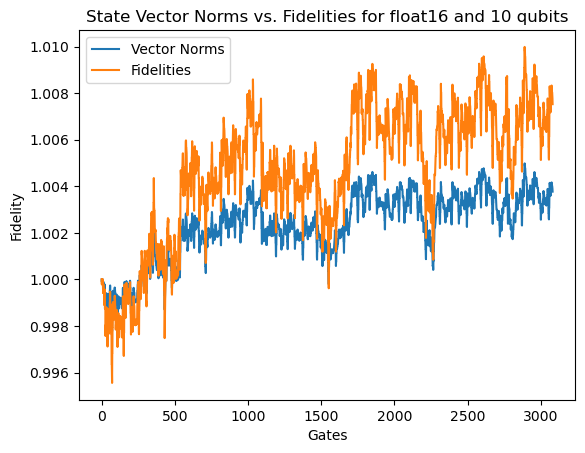

True


In [6]:
load_num_qubits = 10
load_repeat = 10
float16_state_vectors = qt.qload('vector_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(tf.float16)[str(tf.float16).find(' ')+2:-2])
float16_state_vectors_normalized = qt.qload('vector_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(tf.float16)[str(tf.float16).find(' ')+2:-2]+'_normalized')
float16_fidelity = qt.qload('fidelity_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(tf.float16)[str(tf.float16).find(' ')+2:-2])
float16_fidelity_normalized = qt.qload('fidelity_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(tf.float16)[str(tf.float16).find(' ')+2:-2]+'_normalized')
vector_list_baseline_normalized = qt.qload('vector_list_baseline_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_normalized')
vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat))
precision_string = str(tf.float16)[str(tf.float16).find(' ')+2:-2]
float16_norms = np.empty(len(float16_state_vectors))
baseline_norms = np.empty(len(vector_list_baseline))
for i in range(len(float16_state_vectors)):
    float16_norms[i] = float16_state_vectors[i].norm()
for i in range(len(float16_state_vectors)):
    baseline_norms[i] = vector_list_baseline[i].norm()
plt.plot(float16_norms,label="Vector Norms")
plt.plot(float16_fidelity, label="Fidelities")
plt.title('State Vector Norms vs. Fidelities for '+str(precision_string)+" and "+str(load_num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
plt.show()
print(vector_list_baseline_normalized==vector_list_baseline)

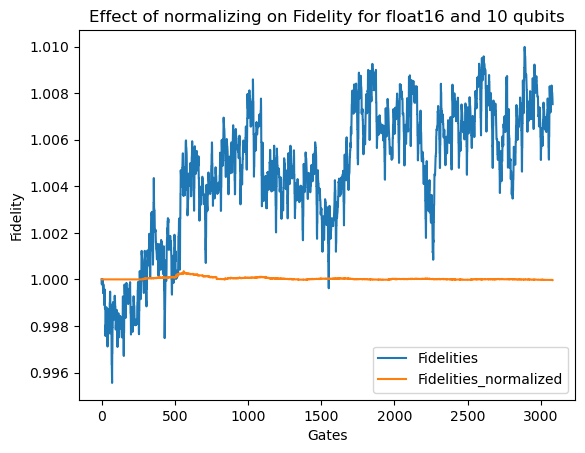

True


In [41]:
plt.plot(float16_fidelity, label="Fidelities")
plt.plot(float16_fidelity_normalized, label="Fidelities_normalized")
plt.title('Effect of normalizing on Fidelity for '+str(precision_string)+" and "+str(load_num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
plt.show()
print(vector_list_baseline_normalized==vector_list_baseline)

In [13]:
# importing math library
import math
  
  
# calculating mantissa and
# exponent of given integer
print(math.frexp(3))
print(math.frexp(np.float32(15.78950483)))
print(math.frexp(-15))

(0.75, 2)
(0.9868440628051758, 4)
(-0.9375, 4)


In [14]:
def me_to_float(m,e):
    return m*(2**e)
me_to_float(-0.9375, 4)
bin(math.frexp(-15))

TypeError: 'tuple' object cannot be interpreted as an integer

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32, 32), dtype=float16, numpy=
array([[0.981, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.981, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.981, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.981, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.981, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.981]], dtype=float16)>>

In [55]:
float16_state_vectors = qt.qload('vector_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(tf.float16)[str(tf.float16).find(' ')+2:-2])
float16_state_vectors[1].full()

array([[0.70703125+0.j],
       [0.        +0.j],
       [0.        +0.j],
       ...,
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j]])

In [60]:
list = 0
for i in gates[1]:
    list +=1
list

32

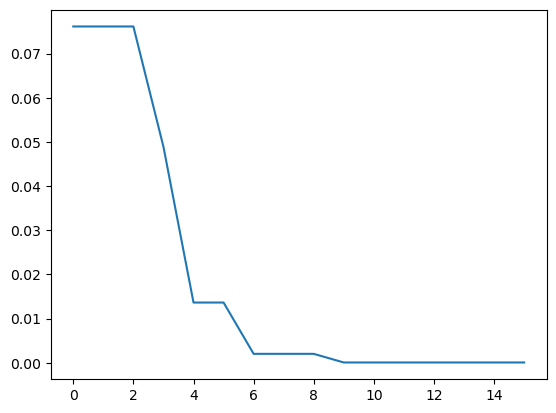

In [102]:
n = 16
y = np.empty(n)
for i in range(n):
    k = np.stack(np.vectorize(roundbits)(tf.cast(np.real(gates[1].full()),dtype=tf.float16),i), axis=1)
    y[i] = np.max(np.abs(k-np.real(gates[1].full())))
plt.plot(y)

In [113]:
k = np.stack(np.vectorize(roundbits)(tf.cast(np.real(gates[1].full()),dtype=tf.float16),64), axis=1)
np.max(np.abs(k-np.real(gates[1].full())))

5.140751128673848e-05

In [123]:
real_state = np.stack(np.vectorize(roundbits)(tf.cast(np.real(float16_state_vectors[1].full()),dtype=tf.float16),8), axis=0)
real_state.shape

(1024, 1)

In [141]:
a = np.finfo(np.float16(45.9))
print("Number of bits in the exponent portion float16 type...\n",a.iexp)
print("Minimum of float16 type...\n",a.min)
print("Maximum of float16 type...\n",a.max)

Number of bits in the exponent portion float16 type...
 5
Minimum of float16 type...
 -65500.0
Maximum of float16 type...
 65500.0


In [187]:
# tells you what the maximum exponent should be. This should be small actually ~1 or 2
load_num_qubits = 10
load_repeat = 0
precision = tf.float16

for normal in [True,False]:
    if normal ==True:
        print("Normalization")
        state_vectors = qt.qload('vector_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized')
    else:
        print("No Normalization")
        state_vectors = qt.qload('vector_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2])
    holder = np.empty((2,2,len(state_vectors),len(state_vectors[1].full())))
    for i,vector in enumerate(state_vectors):
        for index,item in enumerate(vector):
            m_real,e_real = frexp(np.real(item))
            holder[0,0,i,index] = m_real
            holder[0,1,i,index] = e_real
            m_imag,e_imag = frexp(np.imag(item))
            holder[1,0,i,index] = m_imag
            holder[1,1,i,index] = e_imag
    print("max exponent on real values: " +str(np.max(holder[0,1,:,:])))
    print("max exponent on imag values: " +str(np.max(holder[1,1,:,:])))
    print()

Normalization
max exponent on real values: 1.0
max exponent on imag values: 0.0

No Normalization
max exponent on real values: 1.0
max exponent on imag values: 0.0

